In [1]:
import numpy as np
import math
from skimage import io, util
import cv2
import heapq
from collections import defaultdict
# from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
class Graph: 
    def __init__(self,graph): 
        self.graph = graph 
        self.org_graph = [i[:] for i in graph] 
        self.ROW = len(graph) 
        self.COL = len(graph[0])
    '''While there is a path from the source to the sink,
    returns true
    '''
    def breadth_first_search(self, s, t, parent):
        #List that stores whether a node has been visited or not
        visited = [False]*(self.ROW)
        queue=[] #Queue to stores the nodes that are to be traversed 
        queue.append(s) #The source node is appended to the queue
        visited[s] = True
        #Traversing while the queue still has nodes to be traversed
        while len(queue) > 0:
            u = queue.pop(0) #Current node u is the next node from the queue
            #For all the other nodes in the graph
            for ind, v in enumerate(self.graph[u]): 
                if visited[ind] == False and v > 0:
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
        # If the sink was visited, then we return True and look for another traversal
        if visited[t]:
            return True
        else:
            return False    
    # Function for Depth first search 
    # Traversal of the graph
    def dfs(self, graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                self.dfs(graph,i,visited)
    # Returns the min-cut of the given graph 
    def ford_fulkerson(self, source, sink):
        s = 0
        parent = [-1]*(self.ROW) #Tracking the parent of each node
        max_flow = 0 # Initialize a variable to store the max flow of the graph, initially 0
        # Augment the flow while there is path from source to sink 
        while self.breadth_first_search(source, sink, parent) : 
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while not s == source: 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
            # Add path flow to overall flow 
            max_flow += path_flow 
            # Set the desination node to the sink
            v = sink 
            while not v == source: #While v is not 0
                u = parent[v] # u is the parent node for v
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                v = parent[v] #Creates a backwards edge
        visited=len(self.graph)*[False]
        self.dfs(self.graph,s,visited)
        return visited

In [3]:
imgs = []
def normaliseImage(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm

def overlapDiff(patch, patch_length, overlap_region, result, y, x): 
    error = 0
    if x > 0:
        left = patch[:, :overlap_region] - result[y:y+patch_length, x:x+overlap_region]
        error += np.sum(left**2)
    if y > 0:
        up   = patch[:overlap_region, :] - result[y:y+overlap_region, x:x+patch_length]
        error += np.sum(up**2)
    if x > 0 and y > 0:
        corner = patch[:overlap_region, :overlap_region] - result[y:y+overlap_region, x:x+overlap_region]
        error -= np.sum(corner**2)
    return error

def bestPatch(texture, patch_length, overlap_region, result, y, x):
    height, width, _ = texture.shape
    errors = np.zeros((height - patch_length, width - patch_length))
    for h in range(height - patch_length):
        for w in range(width - patch_length):
            patch = texture[h:h+patch_length, w:w+patch_length]
            err = overlapDiff(patch, patch_length, overlap_region, result, y, x)
            errors[h, w] = err

    h, w = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[h:h+patch_length, w:w+patch_length]

def textureSynthesis(texture, patch_length, patches_num, seq=False):
    patches_high, patches_wide = patches_num
    overlap_region = patch_length // 6
    h = (patches_high * patch_length) - (patches_high - 1) * overlap_region
    w = (patches_wide * patch_length) - (patches_wide - 1) * overlap_region
    texture = normaliseImage(texture)
    result = np.zeros((h, w, texture.shape[2]))
    for h in range(patches_high):
        for w in range(patches_wide):
            j = h * (patch_length - overlap_region)
            i = w * (patch_length - overlap_region)
            patch = bestPatch(texture, patch_length, overlap_region, result, j, i)
            patch = minCutPatch(patch, patch_length, overlap_region, result, j, i)   
            result[j:j+patch_length, i:i+patch_length] = patch
            if seq:
                io.imshow(result)
                io.show()
    return result

In [4]:
def minCutPatch(patch, patchLength, overlap, res, y, x):
    patch = patch.copy()
    y_dim, x_dim, _ = patch.shape
    min_Cut = np.zeros_like(patch, dtype=bool)
    result = None
    #for x values greater than 0
    if x > 0:
        p1 = patch[:, :overlap]
        p2 = res[y:y+y_dim, x:x+overlap]
        overlapped_parts_graph = minCutGraph(p1, p2)
        visited_parts = minimum_graph_cut(overlapped_parts_graph)
        result = getResPatch(visited_parts, p1, p2, res)
        for i in range(p1.shape[0]):
            for j in range(p1.shape[1]):
                patch[i][j] = result[i][j]
    #for y values greater than 0
    if y > 0:
        p1 = patch[:overlap, :]
        p2 = res[y:y+overlap, x:x+x_dim]
        p1 = cv2.rotate(p1, cv2.cv2.ROTATE_90_CLOCKWISE)
        p2 = cv2.rotate(p2, cv2.cv2.ROTATE_90_CLOCKWISE)
        overlapped_parts_graph = minCutGraph(p1, p2)
        visited_parts = minimum_graph_cut(overlapped_parts_graph)
        result = getResPatch(visited_parts, p1, p2,res)
        result = cv2.rotate(result, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        for i in range(p1.shape[1]):
            for j in range(p1.shape[0]):
                patch[i][j] = result[i][j]
    return patch

In [5]:
def getResPatch(visited, p1, p2,res):
    node_map = {}
    resPatch = np.zeros(shape=(p1.shape[0],p1.shape[1],3))
    count = 1
    for row in range(len(p1[0])):
        for col in range(len(p1)):
            node_map[count] = (col,row)
            count += 1
    region = np.zeros_like(resPatch)
    for i in range(1,len(visited)-1):
        row = node_map[i][0]
        col = node_map[i][1]
        if visited[i]:
            resPatch[row][col] = np.array(p1[row][col])
            region[row][col] = np.array([255.0,0.0,0.0])
        else:
            resPatch[row][col] = np.array(p2[row][col])
            region[row][col] = np.array([0.0,0.0,255.0])
    imgs.append(region)      
    return resPatch

In [6]:
def minCutGraph(p1, p2):
    n = p1.shape[0] * p2.shape[1] + 2
    minGraph = [[0]*(n) for i in range(n)]
    map_of_nodes = {}
    rowLength = len(p1[0])
    columnLength = len(p1)
#     c = rowLength+columnLength
    c = 1
    for i in range(rowLength):
        for j in range(columnLength):
            map_of_nodes[c] = (j,i)
            c+=1
    c-=1
    twenty = 20
    for row in range(n):
        for col in range(n):
            if (row == 0 and 1<=col<=columnLength) or (col == n-1 and c-columnLength<=row<=c):
                minGraph[row][col] = float('inf')
            elif row != 0:
                if ((row + twenty) < n-2) and (col == row+twenty):
                    prd,pcd = map_of_nodes[row+twenty]
                    prs,pcs = map_of_nodes[row]
                    x = np.square(p1[prs][pcs] - p2[prs][pcs])
                    y = np.square(p1[prd][pcd] - p2[prd][pcd])
                    weight = np.sum(x + y)
                    x = np.square(p1[prs][pcs] - p1[prd][pcd])
                    y = np.square(p2[prs][pcs] - p2[prd][pcd])
                    norm = np.sum(x + y)
                    minGraph[row][row+twenty] = weight/(norm+1e-10)
                if (((row + 1) < (n-2)) and (col == (row + 1))) and (col % columnLength) != 1:
                    prs,pcs = map_of_nodes[row]
                    prd,pcd = map_of_nodes[row+1]
                    x = np.square(p1[prs][pcs] - p2[prs][pcs])
                    y = np.square(p1[prd][pcd] - p2[prd][pcd])
                    weight = np.sum(x + y)
                    x = np.square(p1[prs][pcs] - p1[prd][pcd])
                    y = np.square(p2[prs][pcs] - p2[prd][pcd])
                    norm = np.sum(x + y) 
                    minGraph[row][row+1] = weight/(norm+(1e-10))
    return minGraph

In [7]:
def minimum_graph_cut(overlappedgraph):
    gr = Graph(overlappedgraph)
#     for i in overlappedgraph:
#         print('overlapped',i)
#     im = Image.fromarray(np.uint8(overlappedgraph))
#     im.show()
    #set source
    source = 0
    #set sink
    sink = len(overlappedgraph)
    sink = sink - 1

    #perform min cut
    vii = gr.ford_fulkerson(source, sink)
#     print("vii", vii)
    return vii

(64, 64, 4)


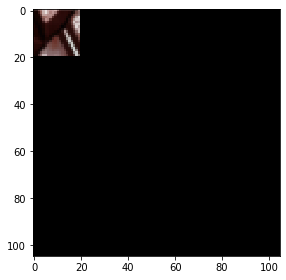

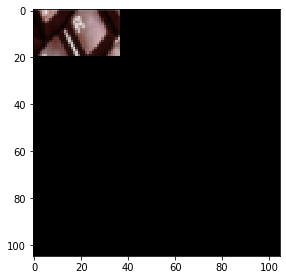

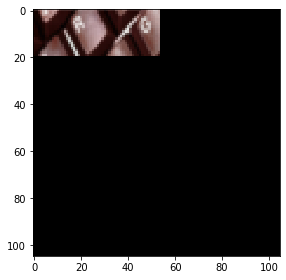

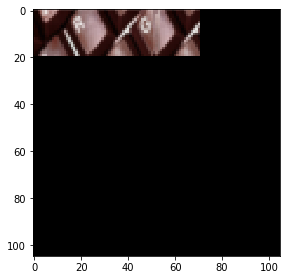

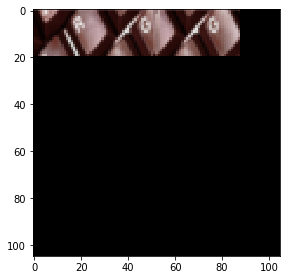

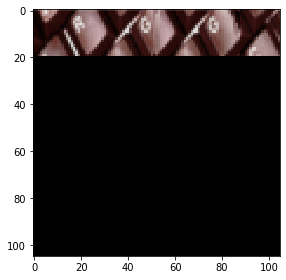

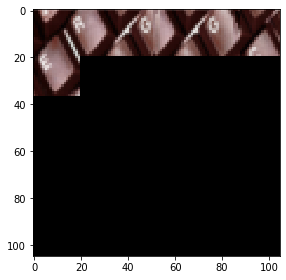

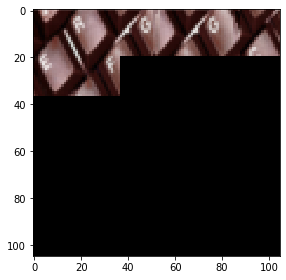

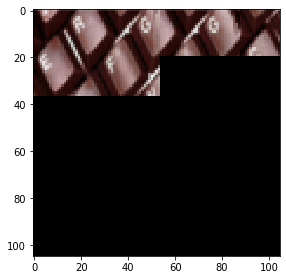

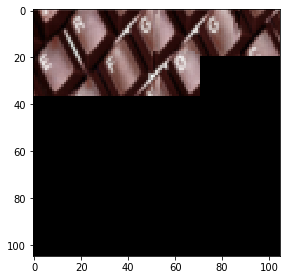

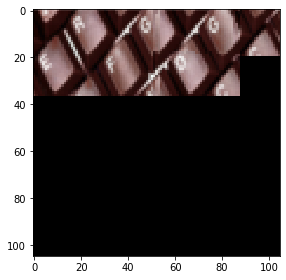

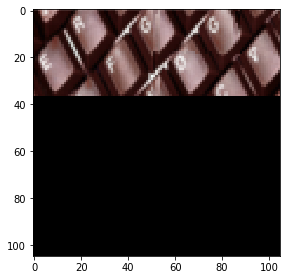

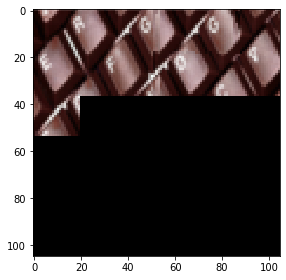

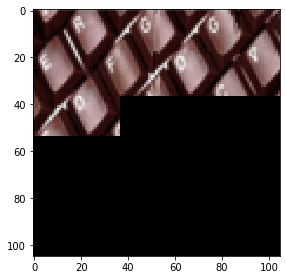

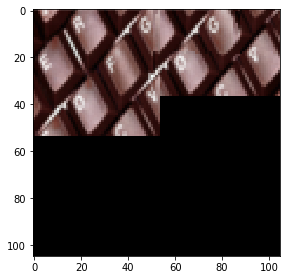

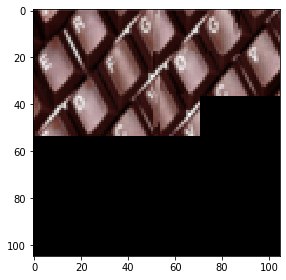

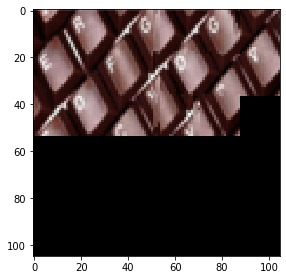

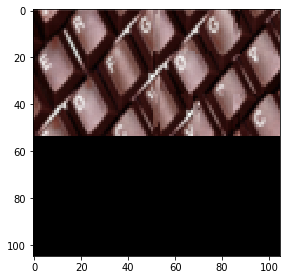

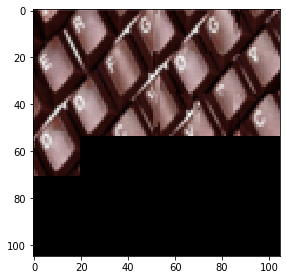

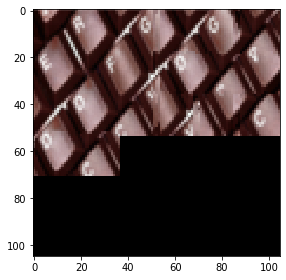

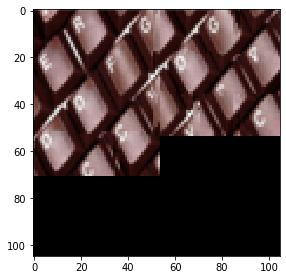

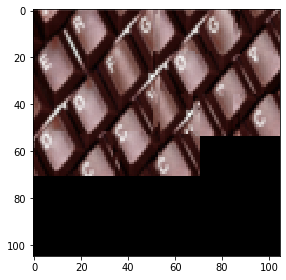

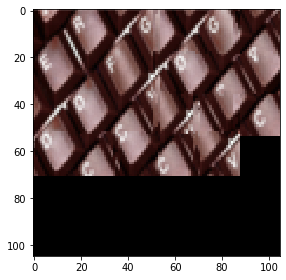

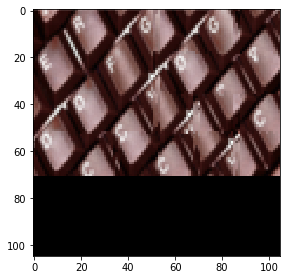

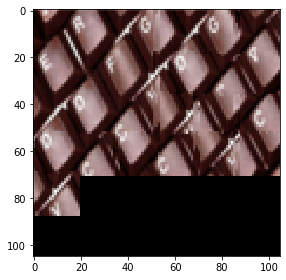

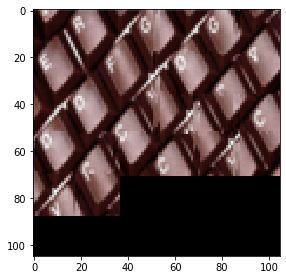

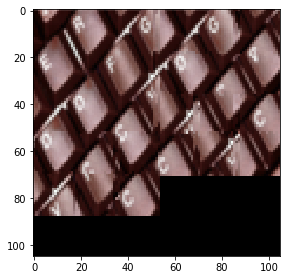

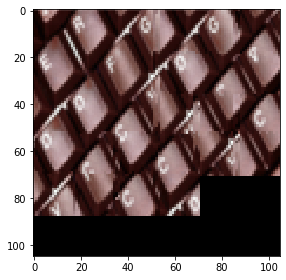

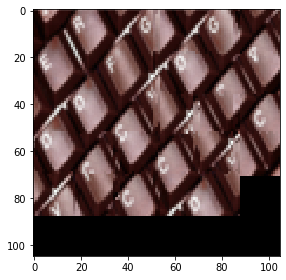

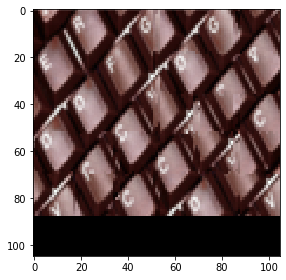

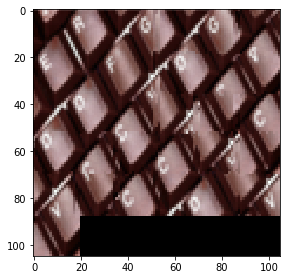

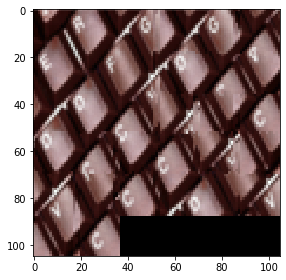

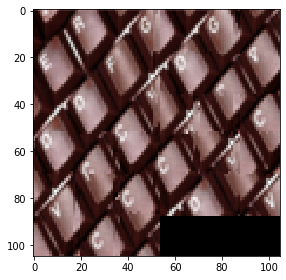

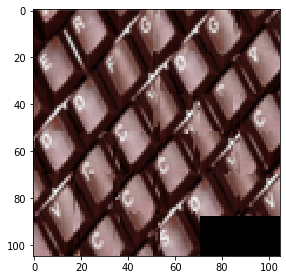

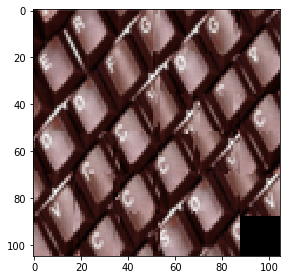

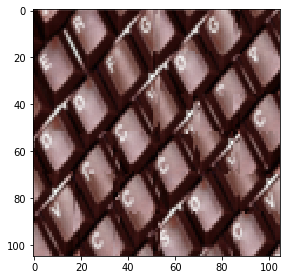

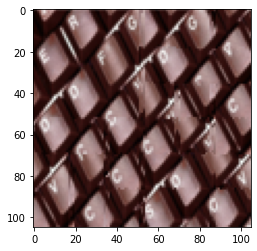

In [8]:
texture = io.imread("img/test3.png")
# texture = io.imread("img/test2.png")
# io.show()
print(texture.shape)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

# plt.imshow(textureSynthesis(texture, 20, (10, 10)))
plt.imshow(textureSynthesis(texture, 20, (6, 6), True))

io.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

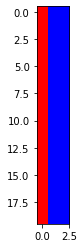

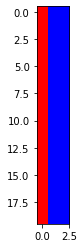

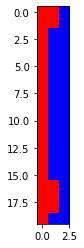

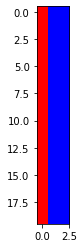

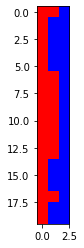

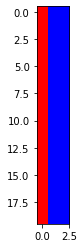

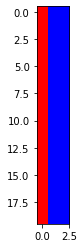

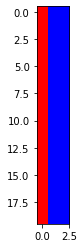

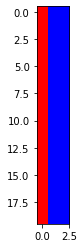

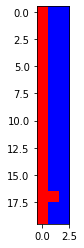

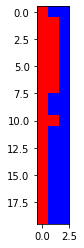

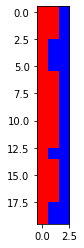

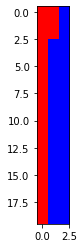

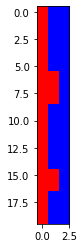

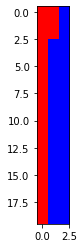

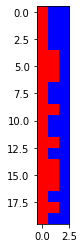

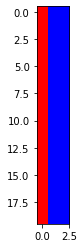

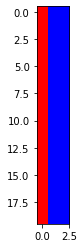

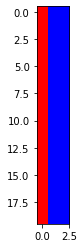

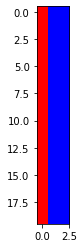

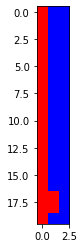

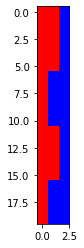

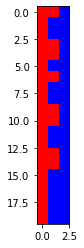

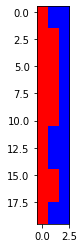

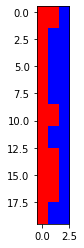

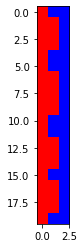

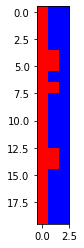

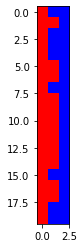

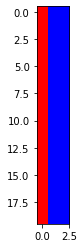

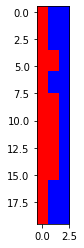

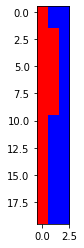

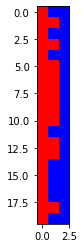

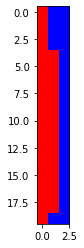

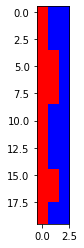

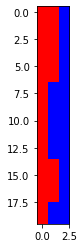

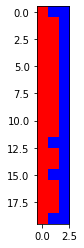

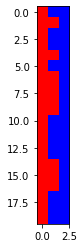

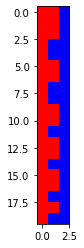

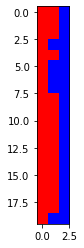

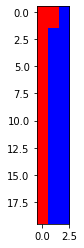

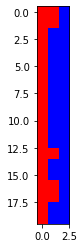

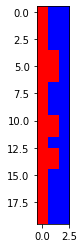

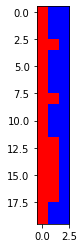

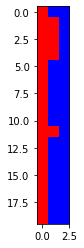

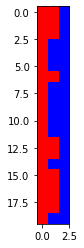

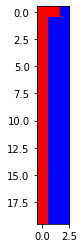

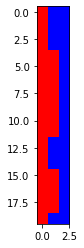

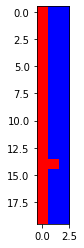

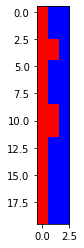

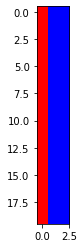

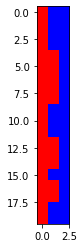

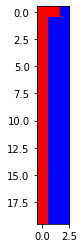

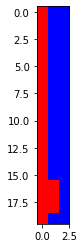

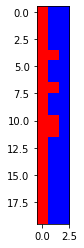

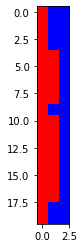

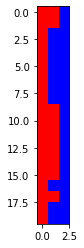

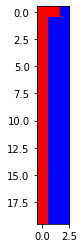

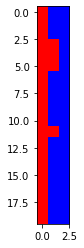

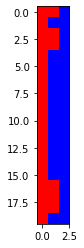

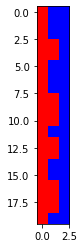

In [9]:
for i,img in enumerate(imgs):
    plt.figure()
    plt.imshow(img)

In [10]:
print(imgs)

[array([[[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[255.,   0.,   0.],
        [  0.,   0., 255.